In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import pandas as pd
from IPython.core.display import HTML
import numpy as np
%matplotlib inline
import glob
import readData
reload(readData) #avoid kernel restart if changed
import re
import databaseQuery
import matplotlib.dates as mdates
from pandas import rolling_median
from datetime import date, datetime 


In [2]:
## Read in the data as a pandas dataframe
# Files should be .csv format in \Data\ subdirectory
# Files should be simply named SAGE_SOUTH or RIV_NORTH, without numerals
allFiles = glob.glob("Data\*.csv") #get all files with csv extension in this subfolder
print allFiles


#Return pandas dataframe with all the data, datetime index
#toggle saveCSV True/False to save a csv of the compiled data

voltage, radius = readData.readCSV(allFiles, saveCSV = False) 
## Read in the metadata as a pandas dataframe
metadata = pd.read_csv('PISTON_DENDROMETER_METADATA.csv',sep=',', dtype=str)

#Create dictionaries between sensor ID and metadata info
Site = dict(zip(metadata['Micron Displacement DSID'], metadata['Site'] )) 
Slope = dict(zip(metadata['Micron Displacement DSID'], metadata['Slope'] )) 
Species = dict(zip(metadata['Micron Displacement DSID'], metadata['Species'] )) 
Tree = dict(zip(metadata['Micron Displacement DSID'], metadata['Tree #'] )) 


['Data\\RIV_NORTH.csv', 'Data\\RIV_SOUTH.csv', 'Data\\SAGE_NORTH.csv', 'Data\\SAGE_SOUTH.csv']


In [3]:
temp = pd.read_csv('temp.csv',sep=',')
temp.index = pd.to_datetime(temp.Timestamp)
temp.head()

,Timestamp,Air Temp WSSR [Sagehorn Ranch WS],flag
Timestamp,,,
2016-04-01 10:05:00,4/1/2016 10:05,15.23,P
2016-04-01 10:10:00,4/1/2016 10:10,15.67,P
2016-04-01 10:15:00,4/1/2016 10:15,15.57,P
2016-04-01 10:20:00,4/1/2016 10:20,16.25,P
2016-04-01 10:25:00,4/1/2016 10:25,16.49,P


In [4]:
tempDaily = temp.groupby(temp.index.date)
minimum = tempDaily.aggregate({pd.np.min}).reset_index()
maximum = tempDaily.aggregate({pd.np.max}).reset_index()
dif = maximum['Air Temp WSSR [Sagehorn Ranch WS]','amax']-minimum['Air Temp WSSR [Sagehorn Ranch WS]','amin']
# group_df.index = group_df.index.to_datetime()
# dailyMin = group_df.resample('30min',fill_method='ffill'

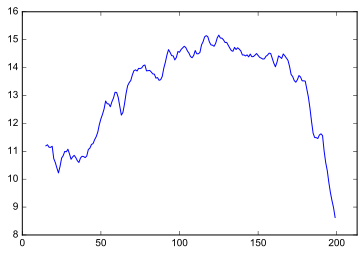

In [5]:
dif.rolling(window=30, center=True).mean().plot()

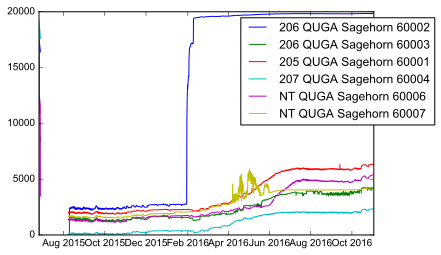

In [6]:
## IDENTIFY GOOD QUGA SENSORS
for column in radius:
    if Species[column]=='QUGA':
        
        plt.plot(radius.index, radius[column], 
#                  color=scalarMap.to_rgba(uniq.index(Tree[column])), 
                 label = (Tree[column] + ' ' + Species[column] + ' ' + Site[column]) + ' ' + column)
plt.legend(bbox_to_anchor=(1.2, 1))

#60002 (maybe), 60001, 60004,60006

In [11]:
#trim to desired sensors
goodSensors = radius[['60001', '60004', '60006']].copy()
#smooth
smoothed = goodSensors
# smoothed = goodSensors.rolling(window=4, center=True).mean()
#trim to start time
startDateTime = pd.to_datetime('2016-04-01 00:00:00')
stopDateTime = pd.to_datetime('2016-11-01 00:00:00')
radiusTR = smoothed[(pd.to_datetime(smoothed.index) > startDateTime) & 
                    (pd.to_datetime(smoothed.index) < stopDateTime)]
#zero initial radius
radiusMin = radiusTR.apply(np.min)
radiusZeroed =  radiusTR-radiusMin

C:\Users\wjh\Anaconda\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=True).median()


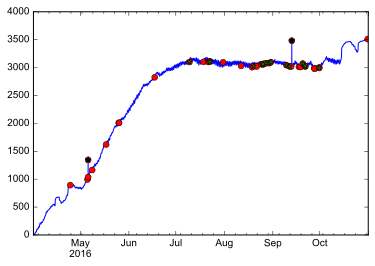

In [12]:
#OUTLIER DETECTION AND ELIMINATION WITH ROLLING MEDIAN FILTER
#from python4oceanographers

kw = dict(marker='o', linestyle='none', color='r', alpha=0.3)

radiusZeroed['60001median'] = rolling_median(radiusZeroed['60001'], window=3, center=True).fillna(method='bfill').fillna(method='ffill')

difference = np.abs(radiusZeroed['60001'] - radiusZeroed['60001median'])
outlier_2 = difference > 2
outlier_3 = difference > 3
outlier_10 = difference > 10


fig, ax = plt.subplots()
radiusZeroed['60001'].plot()
radiusZeroed['60001'][outlier_2].plot(**kw)
kw.update(color='g', marker='*', alpha=1)
radiusZeroed['60001'][outlier_3].plot(**kw)
kw.update(color='k', marker='*', alpha=1)
radiusZeroed['60001'][outlier_10].plot(**kw)

# _ = ax.set_ylim(-50, 60)

In [13]:
radiusZeroed['60001'][outlier_10] = np.nan
radiusZeroed['60001'] = radiusZeroed['60001'].fillna(method='bfill')
radiusZeroed.drop('60001median',axis=1,inplace=True)

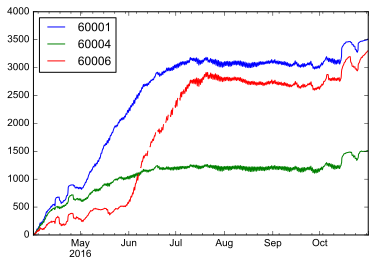

In [14]:
radiusZeroed.plot()
#Tree 60006's delayed growth may be attributed to its north-facing aspect; other two are north-facing
#add rain?

In [15]:
## Import from mySQL database 
#Convert datetime stamps to strings for the sql query
dateStart = str(startDateTime.year) + '-' + str(startDateTime.month) + '-' + str(startDateTime.day)
dateStop =  str(stopDateTime.year) + '-' + str(stopDateTime.month) + '-' + str(stopDateTime.day)

#here we make use of external .py file with odmquery function (thanks Collin!) to get data from the database
#1672 = cumulative WY precip, in mm
#1785 = Rainfall mm TB4 WSAM RWS_Rain_TB4_Tot2015-03-26 (ongoing)Rainfall mmAngelo Meadow WSwsam0 to 700TB4mm-L Rain Gage
#2958 = Barometric Pressure, WSSR, mBar
#2959 = Rainfall, WSSR, mm
#3048 = Rainfall Cumulative mm Sagehorn
rain = databaseQuery.odmquery(dateStart, dateStop, '2959', True)

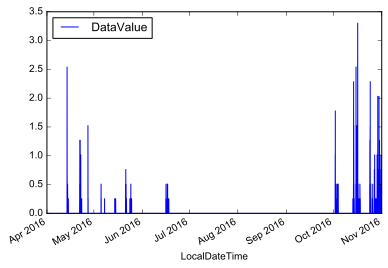

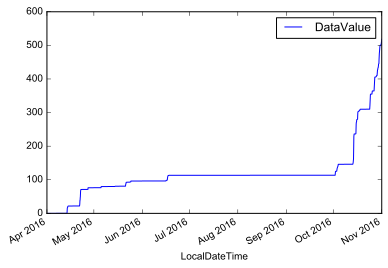

In [16]:
rain.plot()
cumsum = rain.cumsum()
cumsum.plot()

In [22]:
dsids = ['60001', '60004','60006']
newTags = ['4','1','165']
newTagIDs = dict(zip(dsids,newTags))

In [23]:
newTagIDs

{'60001': '4', '60004': '1', '60006': '165'}

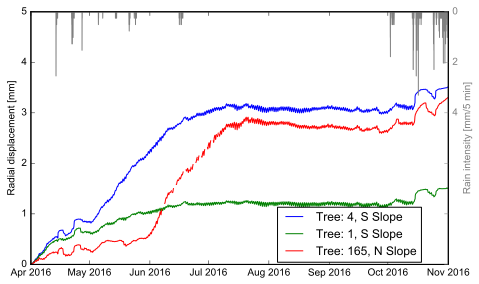

In [24]:
fig, ax = plt.subplots(1, 1, figsize=((19/2.54),(11.5/2.54)))
twin = ax.twinx()

for column in radiusZeroed:
    ax.plot(radiusZeroed.index, radiusZeroed[column]/1000, 
#                  color=scalarMap.to_rgba(uniq.index(Tree[column])), 
                 label = ('Tree: ' + newTagIDs[column] + ', ' + Slope[column] + ' Slope'))
ax.legend(bbox_to_anchor=(.95, .25))
ax.set_ylabel('Radial displacement [mm]')
ax.set_ylim([0,5])

twin.plot(rain.index,rain['DataValue'],c='grey')
twin.set_ylim([0,10])

twin.invert_yaxis()
twin.set_ylabel('Rain intensity [mm/5 min]', color='grey')

twin.set_yticklabels(['0','2','4','','',''])
twin.tick_params(axis='y', colors='grey')
plt.savefig('Figs\\Seasonal-Piston-Dendrometer.pdf')
#Switch to mm!!
#RAIN INTENSITY AXIS TO 4 ONLY

In [25]:
radiusZeroed.tail()

,60001,60004,60006
2016-10-31 21:30:00,3507.68,1507.32,3298.72
2016-10-31 22:00:00,3507.68,1507.36,3297.92
2016-10-31 22:30:00,3507.68,1507.36,3297.92
2016-10-31 23:00:00,3507.68,1507.36,3297.92
2016-10-31 23:30:00,3507.68,1507.36,3297.92


In [26]:
#normalize each day's values to 00:00 hours, if value exists at that time?
group_df = radiusZeroed.groupby(radiusZeroed.index.date)
group_df = group_df.aggregate({pd.np.min})
group_df.index = group_df.index.to_datetime()
dailyMin = group_df.resample('30min',fill_method='ffill')
dailyMin.head()

C:\Users\wjh\Anaconda\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill()


,60001,60004,60006
,amin,amin,amin
2016-04-01 00:00:00,0.0,0.0,0.0
2016-04-01 00:30:00,0.0,0.0,0.0
2016-04-01 01:00:00,0.0,0.0,0.0
2016-04-01 01:30:00,0.0,0.0,0.0
2016-04-01 02:00:00,0.0,0.0,0.0


In [27]:
daily=radiusZeroed.join(dailyMin)
daily['60001_dif'] = daily['60001']-daily['60001', 'amin']
daily['60004_dif'] = daily['60004']-daily['60004', 'amin']
daily['60006_dif'] = daily['60006']-daily['60006', 'amin']
dailyZeroed = daily[['60001_dif', '60004_dif', '60006_dif']].copy()


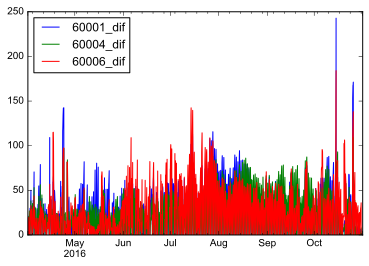

In [28]:
dailyZeroed.plot()

In [29]:
#

#Take the average across all sensors, ignoring NaNs 
allTogether = dailyZeroed.mean(axis=1).to_frame()
allTogether.columns=['dailyZeroed']


In [30]:
allTogether["time"] = allTogether.index.time
allTogether['date'] = allTogether.index.date

In [31]:
allTogether.tail()

,dailyZeroed,time,date
2016-10-31 21:30:00,NaN,21:30:00,2016-10-31
2016-10-31 22:00:00,NaN,22:00:00,2016-10-31
2016-10-31 22:30:00,NaN,22:30:00,2016-10-31
2016-10-31 23:00:00,NaN,23:00:00,2016-10-31
2016-10-31 23:30:00,NaN,23:30:00,2016-10-31


In [32]:
april2016 = allTogether[
    (allTogether.index > pd.to_datetime('2016-04-01 00:00:00')) &
    (allTogether.index < pd.to_datetime('2016-05-01 00:00:00'))]
may2016 = allTogether[
    (allTogether.index > pd.to_datetime('2016-05-01 00:00:00')) &
    (allTogether.index < pd.to_datetime('2016-06-01 00:00:00'))]
june2016 = allTogether[
    (allTogether.index > pd.to_datetime('2016-06-01 00:00:00')) &
    (allTogether.index < pd.to_datetime('2016-07-01 00:00:00'))]
july2016 = allTogether[
    (allTogether.index > pd.to_datetime('2016-07-01 00:00:00')) &
    (allTogether.index < pd.to_datetime('2016-08-01 00:00:00'))]
august2016 = allTogether[
    (allTogether.index > pd.to_datetime('2016-08-01 00:00:00')) &
    (allTogether.index < pd.to_datetime('2016-09-01 00:00:00'))]
september2016 = allTogether[
    (allTogether.index > pd.to_datetime('2016-09-01 00:00:00')) &
    (allTogether.index < pd.to_datetime('2016-10-01 00:00:00'))]
october2016 = allTogether[
    (allTogether.index > pd.to_datetime('2016-10-01 00:00:00')) &
    (allTogether.index < pd.to_datetime('2016-11-01 00:00:00'))]


In [33]:
# example from http://nipunbatra.github.io/2015/06/timeseries/
daily_radius = pd.pivot_table(allTogether, index=["time"], columns=["date"], values=["dailyZeroed"])

April = pd.pivot_table(april2016, index=["time"], columns=["date"], values=["dailyZeroed"])

May = pd.pivot_table(may2016, index=["time"], columns=["date"], values=["dailyZeroed"])

June = pd.pivot_table(june2016, index=["time"], columns=["date"], values=["dailyZeroed"])

July = pd.pivot_table(july2016, index=["time"], columns=["date"], values=["dailyZeroed"])

August = pd.pivot_table(august2016, index=["time"], columns=["date"], values=["dailyZeroed"])

September = pd.pivot_table(september2016, index=["time"], columns=["date"], values=["dailyZeroed"])

October = pd.pivot_table(october2016, index=["time"], columns=["date"], values=["dailyZeroed"])


In [34]:
#Resulting 'month' dataframe has half-hourly time of day for index (rows), 
# and each column is a single day of the month
April.head()

dailyZeroed                                                         \
date      2016-04-01 2016-04-02 2016-04-03 2016-04-04 2016-04-05 2016-04-06   
time                                                                          
00:00:00         NaN   0.000000   0.000000   0.000000   2.440000   3.760000   
00:30:00    0.160000   1.573333   1.826667   0.933333   4.506667   4.493333   
01:00:00    1.280000   3.133333   3.506667   2.520000   6.386667   6.080000   
01:30:00    1.493333   3.893333   5.426667   4.120000   8.546667   7.066667   
02:00:00    2.546667   4.786667   7.186667   5.040000  10.440000   7.920000   

                                                        ...                 \
date     2016-04-07 2016-04-08 2016-04-09 2016-04-10    ...     2016-04-21   
time                                                    ...                  
00:00:00   0.000000   0.000000   0.000000   0.000000    ...       0.746667   
00:30:00   0.906667   1.000000   1.333333   0.906667    ...       1.480000   
01:00:00   2.240000   2.320000   2.760000   1.813333    ...       2.186667   
01:30:00   3.173333   4.106667   4.866667   3.626667    ...       2.253333   
02:00:00   4.640000   5.973333   6.746667   4.586667    ...       2.586667   

                                                                            \
date     2016-04-22 2016-04-23 2016-04-24 2016-04-25 2016-04-26 2016-04-27   
time                                                                         
00:00:00   0.000000   0.000000   0.186667   0.773333  60.920000  24.320000   
00:30:00   1.720000   5.626667   0.240000   0.853333  60.946667  24.360000   
01:00:00   3.466667  14.733333   0.146667   0.973333  60.986667  24.453333   
01:30:00   5.186667  21.373333   0.280000   0.906667  60.960000  24.866667   
02:00:00   6.280000  34.880000   0.160000   0.893333  61.013333  24.960000   

                                           
date     2016-04-28 2016-04-29 2016-04-30  
time                                       
00:00:00   1.426667  23.920000  13.773333  
00:30:00   1.880000  24.586667  14.413333  
01:00:00   1.933333  24.813333  15.240000  
01:30:00   1.773333  25.280000  15.666667  
02:00:00   1.760000  25.280000  16.173333  

[5 rows x 30 columns]

In [35]:
#now, average all days of month into one day
April = April.mean(axis=1).to_frame()
May = May.mean(axis=1).to_frame()
June = June.mean(axis=1).to_frame()
July = July.mean(axis=1).to_frame()
August = August.mean(axis=1).to_frame()
September = September.mean(axis=1).to_frame()
October = October.mean(axis=1).to_frame()

In [36]:
months = [April, May, June, July, August, September, October]
April.name = 'April'
May.name = 'May'
June.name = 'June'
July.name = 'July'
August.name = 'August'
September.name = 'September'
October.name = 'October'

In [37]:
for month in months:
    month = pd.DataFrame(month)


In [38]:
for month in months:
    #bogus day for plotting purposes - all we care about is the time
    month['DAY'] = date.today()
    month['TIME'] = month.index
#     month['datetime']=month.apply(lambda x: x['DAY']+pd.to_datetime(x['TIME']), axis=1)
#     month['datetime']=pd.to_datetime(month['DAY'] + ' ' + month['TIME'])
    month.index=month.apply(lambda x: datetime.combine(x['DAY'], x['TIME']), axis=1)

In [39]:
all_linestyles=['solid', 'dashed', 'dashdot', 'dotted', #(0, (2.0, 4.0)),(0, (4.0, 2.0)),(0, (1.0, 3.0))]
                'solid', 'dashed', 'dotted']
month_names = ['April','May','June','July','August','September','October']
linestyles = all_linestyles[0:len(months)]
month_linestyle =  dict(zip(month_names, linestyles))

In [40]:
for month in months:
    month[0] = month[0]-month[0].iloc[0]

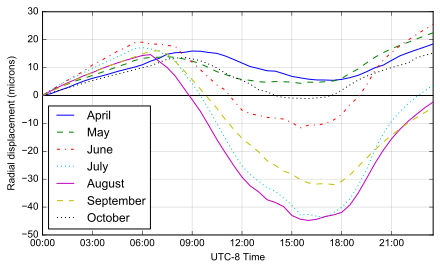

In [71]:
# plt.switch_backend('agg')
# plt.switch_backend('qt4agg')
plt.show()

fig, ax = plt.subplots(1, figsize=(7,4))
        


for month in months:

    ax.plot(month.index.values, month[0].values, label=month.name,
                  linestyle = month_linestyle[month.name],zorder=10)
ax.plot([month.index.values[0],month.index.values[-1]],[0,0],color='black',zorder=-10)

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

plt.legend(loc='lower left')
plt.grid(ls='solid', alpha=0.2)

plt.ylabel('Radial displacement (microns)')
plt.xlabel('UTC-8 Time')

plt.savefig('Figs//Diurnal_PistonDendro_Patterns_By_Month.pdf')

#add average sunshine?

In [96]:
month[0]

2017-03-13 00:00:00     0.000000
2017-03-13 00:30:00     0.921333
2017-03-13 01:00:00     1.846222
2017-03-13 01:30:00     2.667556
2017-03-13 02:00:00     3.582667
2017-03-13 02:30:00     4.440889
2017-03-13 03:00:00     5.332889
2017-03-13 03:30:00     6.072889
2017-03-13 04:00:00     6.911111
2017-03-13 04:30:00     7.678667
2017-03-13 05:00:00     8.406222
2017-03-13 05:30:00     9.205333
2017-03-13 06:00:00     9.952444
2017-03-13 06:30:00    10.654667
2017-03-13 07:00:00    11.752889
2017-03-13 07:30:00    13.000000
2017-03-13 08:00:00    13.418222
2017-03-13 08:30:00    13.552444
2017-03-13 09:00:00    13.164889
2017-03-13 09:30:00    12.430667
2017-03-13 10:00:00    11.226667
2017-03-13 10:30:00     9.854667
2017-03-13 11:00:00     7.968889
2017-03-13 11:30:00     6.564889
2017-03-13 12:00:00     5.453333
2017-03-13 12:30:00     4.057778
2017-03-13 13:00:00     2.038222
2017-03-13 13:30:00     1.360444
2017-03-13 14:00:00    -0.069333
2017-03-13 14:30:00    -0.705778
2017-03-13

In [97]:
month.dtypes

0                  float64
TIME                object
datetime    datetime64[ns]
DAY                 object
dtype: object